,time_spent_risk,cells,selfish,time_spent_prop,count_effort,Honesty_Humility,Extraversion,Agreeableness,min_offer
0,43000,26,60,31000,20,4.2,3.0,2.8,50
1,12000,7,20,38000,20,1.9,4.4,2.9,50
2,88000,50,20,69000,12,3.3,3.8,3.4,80
3,24000,50,60,26000,14,3.6,3.8,2.6,50
4,137000,24,60,43000,4,3.6,2.5,2.7,100


<Figure size 432x288 with 0 Axes>

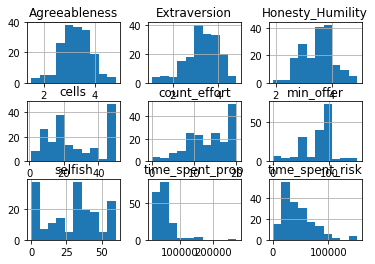

<Figure size 432x288 with 0 Axes>

In [151]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

#fix rnd seed
np.random.seed(7)

MAX_GAIN = 200

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")
df = df.dropna()
df = df.dropna()
df = df[['time_spent_risk', 'cells', 'selfish', 'time_spent_prop', 'count_effort',
         'Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]

MAX_ACCEPTABLE_MIN_OFFER = 150
df = df[df['min_offer'] <= MAX_ACCEPTABLE_MIN_OFFER]


#print(df[50:])

# Show head and histograms
display(df.head())
df.hist()

# Plot sample figure for min_offers
plt.figure()

#x = range(0, len(df['prop']))
#x1 = df['min_offer']

#plt.plot(x, x1)

In [152]:
# sb.pairplot(df, x_vars=('prop','other_resp','other_prop'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
# sb.pairplot(df, x_vars=('cells', 'selfish','count_effort'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
# sb.pairplot(df, x_vars=('Honesty_Humility', 'Extraversion','Agreeableness'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
# sb.pairplot(df, x_vars=('time_spent_prop', 'time_spent_risk'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')

In [153]:
#manual ablation
#df = df.drop(columns=['cells','selfish','count_effort','Honesty_Humility','Extraversion','Agreeableness','time_spent_risk','time_spent_prop'])

In [154]:
from sklearn.linear_model import LinearRegression
# Split into inputs and oututs
x = df.iloc[:, :-1].values

y = df.iloc[:, -1:].values
NB_FEATURES = x.shape[1]
NORMALISE_DATA = True


x = df.values[:, :-1]
y = df.values[:, -1:]

if NORMALISE_DATA:
    x_min = x.min(axis=0)
    x_max = x.max(axis=0)
    x = (x - x_min) / (x_max - x_min)
    
NB_FEATURES = x.shape[1]
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)
#print(xTrain)
#print(yTrain)

# regressor = LinearRegression(copy_X=True).fit(xTrain, yTrain)

# print("Intercept:", regressor.intercept_)
# print("Coef:", regressor.coef_)

# yPredict = regressor.predict(xTest)
# print("R2:", r2_score(yTest, yPredict))

# out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPredict)})
# #print(out_data)

# out_data.plot(figsize=(30,10))

In [155]:
@np.vectorize
def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)

@np.vectorize
def sigmoid1024(x):
    base = 2000.0**2
    return (base**x/(base**x + 1))

@np.vectorize
def sigmoid128(x):
    return (128**x/(128**x + 1))

# @np.vectorize
# def loss(x):
#     x = (x+10) / 40
#     return (1 - (sigmoid1024(x) * np.cos(x/np.pi))) / 2
    
# @np.vectorize
# def gain(x):
#     return 2 - loss(x)

# @np.vectorize
def gain(x):
    x = (x - 32) / 40
    return (sigmoid1024(x) *  np.cos(x/np.pi))

@np.vectorize
def loss(x):
    x_ = (x) / 40
    x = (x + 0) / 40
    return (1 - sigmoid1024(x) *  np.cos(x_/np.pi))
    #return 1 - gain(x+24)

def gain(x):
    return 1 - loss(x)

Max value:  15.815815815815824 0.0


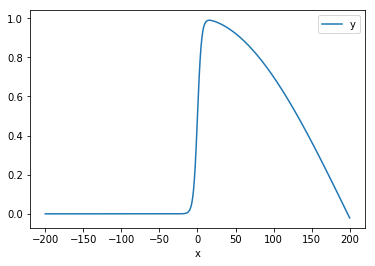

In [156]:
x = np.linspace(-200, 200, 1000)
y = gain(x)
print("Max value: ", x[y.argmax()], gain(-200))

df = pd.DataFrame({'x':x, 'y':y})
df.plot.line(x='x', y='y')

Min value:  15.815815815815824


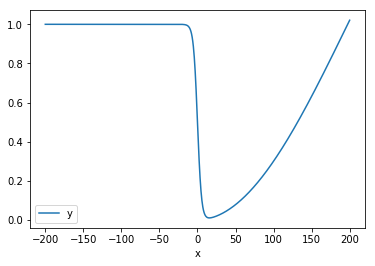

In [157]:
y = loss(x)
print("Min value: ", x[y.argmin()])

df = pd.DataFrame({'x':x, 'y':y})
df.plot.line(x='x', y='y')

In [159]:
class DACombine(object):
    def __init__(self, size=None, nb_features=NB_FEATURES, max_gain=MAX_GAIN):
        self.size = size
        self.nb_features = nb_features
        self.max_gain = max_gain
    
    def fit_predict(self, xTrain, yTrain, size=None, distance=10, upsample=True, include_xy=False, retarget=False, distribution=False, combine=False):
        """
        :param size: (int) size of the new generated dataset
        :param distance: (int) distance between parents or similar items
        :param upsample: (bool) if True, try balance the dataset
        :param include_xy: (bool) if True, include xTrain and yTrain to the data (on top of size items)
        :param retarget: (bool) if True, set all targets to the nearest higher multiple of distance without generating new samples
        :param distribution: (bool) if True, create new sample based on percentiles of features's std
        :param combine: (bool) if True: combine different methods (dist + retarget)
        """
        
        size = size or self.size or len(xTrain) * 4
        if combine:
            if distribution:
                xTrain, yTrain = self.dist_resample(xTrain, yTrain, size)
        else:
            if retarget:
                return self.retarget(xTrain, yTrain, distance)

            if distribution:
                return self.dist_resample(xTrain, yTrain, size)
    
        indices = np.arange(self.nb_features)
        np.random.shuffle(indices)
        targets = yTrain.ravel()
        if upsample:
            targets, counts = np.unique(yTrain, return_counts=True)
            #NOTE: minimize selection of target with only one sample
            probs = (1 - counts/counts.sum())**2
            probs[counts==1] = probs.min()
            probs /= probs.sum()
        else:
            targets = yTrain.ravel()
            probs = None
        xRes = []
        yRes = []
        if include_xy:
            xRes.extend(xTrain)
            yRes.extend(yTrain.ravel())
        for _ in range(size):
            target = np.random.choice(targets, p=probs)
            target_mask = (yTrain.ravel()<target+distance) & (yTrain.ravel()>=(target))
            xTrain_target = xTrain[target_mask]
            i = np.random.randint(xTrain_target.shape[0])
            j = np.random.randint(xTrain_target.shape[0])
            x = np.zeros_like(xTrain_target[0])
            np.random.shuffle(indices)
            split = np.random.randint(self.nb_features)
            mask_i = indices[:split]
            mask_j = indices[split:]
            x[mask_i] = xTrain_target[i, mask_i]
            x[mask_j] = xTrain_target[j, mask_j]
            xRes.append(x)
            yRes.append(target)
        xRes = np.array(xRes)
        yRes = np.array(yRes)
        if combine and retarget:
            return self.retarget(xRes, yRes, distance)
        return np.array(xRes), np.array(yRes)

    def retarget(self, xTrain, yTrain, distance=10):
        yNew = yTrain.ravel().copy()
        for y in np.arange(self.max_gain, 0, -distance):
            mask = (yNew <= y) & (yNew > y-distance)
            yNew[mask] = y + distance    # np.random.randint(0, distance, mask.shape)[mask]
        yNew = np.array(yNew)
        yNew[yNew > self.max_gain] = self.max_gain
        return xTrain, yNew
    
    def dist_resample(self, xTrain, yTrain, size=None, std_ratio=0.1):
        size = size or self.size or len(xTrain) * 4
        xTrain_mean = xTrain.mean()
        xTrain_std = xTrain.std()
        xNew = []
        yNew = []
        for _ in range(size):
            idx = np.random.randint(0, xTrain.shape[0])
            x = np.random.normal(xTrain[idx], xTrain_std*std_ratio)
            y = yTrain[idx]
            xNew.append(x)
            yNew.append(y)
        return np.array(xNew), np.array(yNew)
            

    def fit_resample(self, xTrain, yTrain, size=None, distance=5, include_xy=True):
        return self.fit_predict(xTrain, yTrain, size=size, distance=distance, include_xy=include_xy)

In [408]:
#Keras model: 2
#keras
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import multiply
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import sys


def sigmoid1024_tf(x):
    return (1024**x) / (1024**x + 1)

def sigmoid_tf(x):
    return K.sigmoid(x)

def gain_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(10.0)
    x = tf.math.subtract(y_true, y_pred)
    x = tf.math.truediv(x, ten)
    left_mul = sigmoid_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.multiply(left_mul, right_mul)

def loss_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(10.0)
    x0 = tf.math.subtract(y_true, y_pred)
    x = tf.math.truediv(x0, ten)
    left_mul = sigmoid_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.subtract(one*2, tf.math.multiply(left_mul, right_mul))

def _keras_model(loss=None, metrics=None, nb_features=NB_FEATURES):
    """
    build a simple regression model
    :param loss: (str|callable, default: loss_tf)
    """
    if loss is None:
        loss = loss_tf
    if metrics is None:
        metrics = ["mse"]
    model = Sequential()
    model.add(Dense(256, input_dim=nb_features, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss=loss, optimizer='nadam', metrics=metrics)
    return model

def _keras_linear_regression(loss=None, metrics=None):
    if loss is None:
        loss = "mse"
    if metrics is None:
        metrics = ["acc"]
    model = Sequential()
    model.add(Dense(1, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'), activation)
    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

def _keras_classifier(nb_classes, loss=None, metrics=None):
    if loss is None:
        loss = "mse"
    if metrics is None:
        metrics = ["acc"]
    model = Sequential()
    model.add(Dense(1, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(nb_classes, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='adam', metrics=metrics)

def keras_linear_regression(loss=None, metrics=None, nb_epoch=100, batch_size=32, verbose=False):
    build_fn = lambda : _keras_linear_regression(loss, metrics)
    return KerasRegressor(build_fn=build_fn, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)
    
def keras_model(loss=None, metrics=None, nb_epoch=100, batch_size=32, verbose=False, nb_features=NB_FEATURES):
    build_fn = lambda : _keras_model(loss, metrics, nb_features=nb_features)
    return KerasRegressor(build_fn=build_fn, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)

def keras_classifier(nb_classes): pass

**Metrics**

In [204]:
MAX_GAIN = 200.0

def gain2(min_offer, predicted):
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res

def gain_mean2(min_offer, predicted):
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res.mean()

**Model: No data Augmentation**

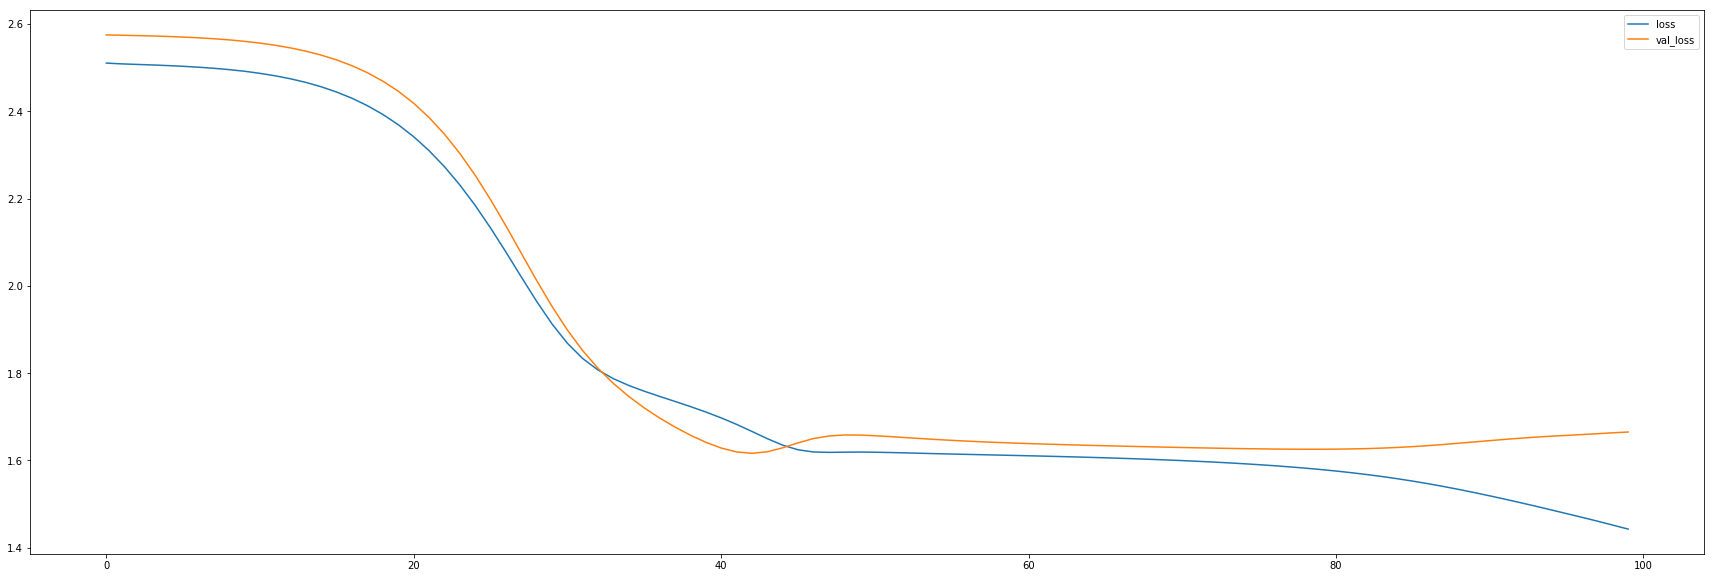

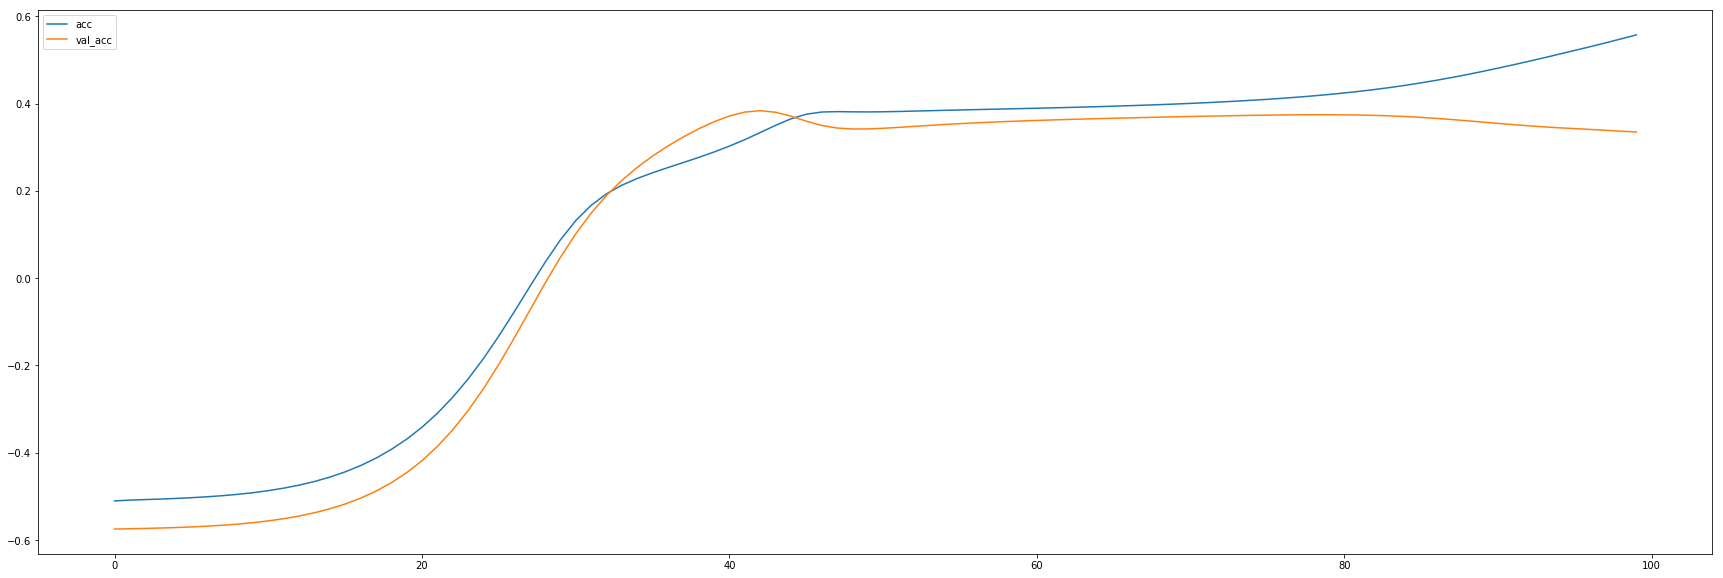

In [217]:
#sci-kit like training
model = keras_model(loss=loss_tf, metrics=[gain_tf])
da = DACombine()
xTrain_a, yTrain_a = xTrain, yTrain
split = int(xTrain.shape[1] * 0.25)
xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
#xTrain_a, yTrain_a = da.fit_predict(xTrain, yTrain, size=1024, distance=10)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'),  validation_data=(xVal, yVal), epochs=100, batch_size=60, verbose=0)
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot(figsize=(30,10))

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot(figsize=(30, 10))

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  31.848183


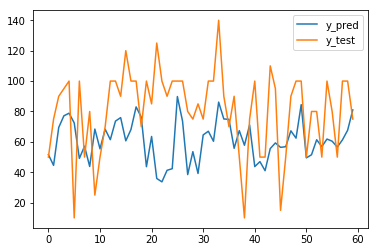

In [218]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean2(yTest.ravel(), yPred.ravel()))

**Model with data augmentation**

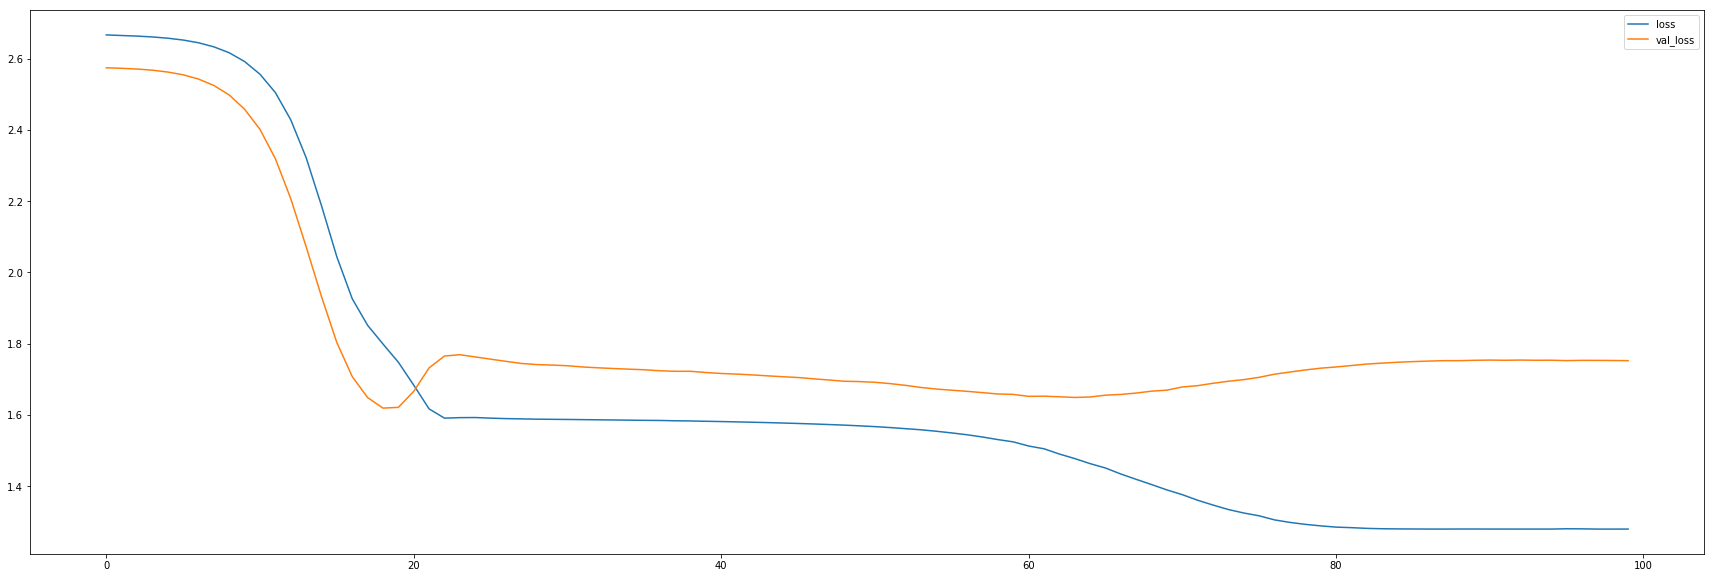

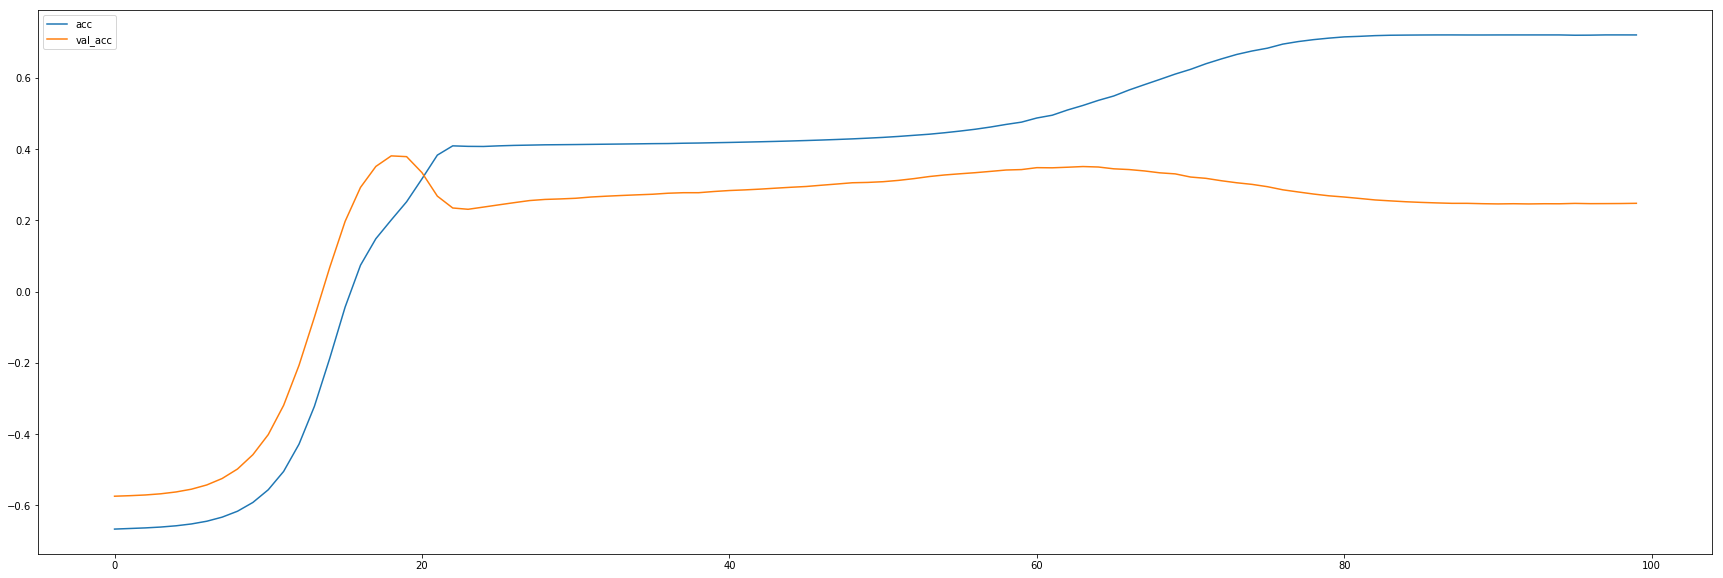

In [219]:
#sci-kit like training
model = keras_model(loss=loss_tf, metrics=[gain_tf])
da = DACombine()
split = int(xTrain.shape[1] * 0.25)
xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
xTrain_a, yTrain_a = da.fit_predict(xTrain_a, yTrain_a, size=xTrain_a.shape[1]*16, distance=10, retarget=True, distribution=True, combine=True)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'), validation_data=(xVal, yVal), epochs=100, batch_size=64, verbose=0)
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot(figsize=(30,10))

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot(figsize=(30, 10))

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  42.14113


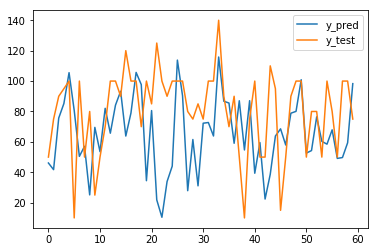

In [220]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean2(yTest.ravel(), yPred.ravel()))

** Model using _mse_ loss and data augmentation**

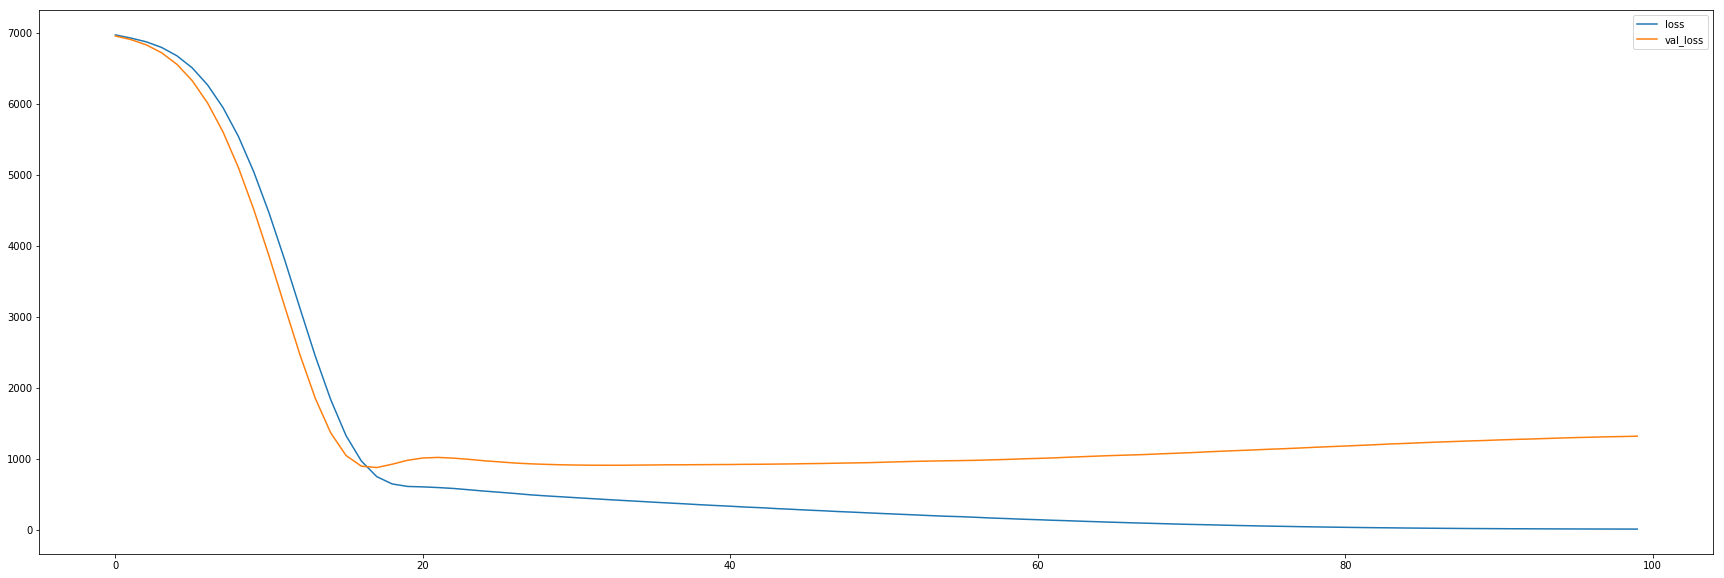

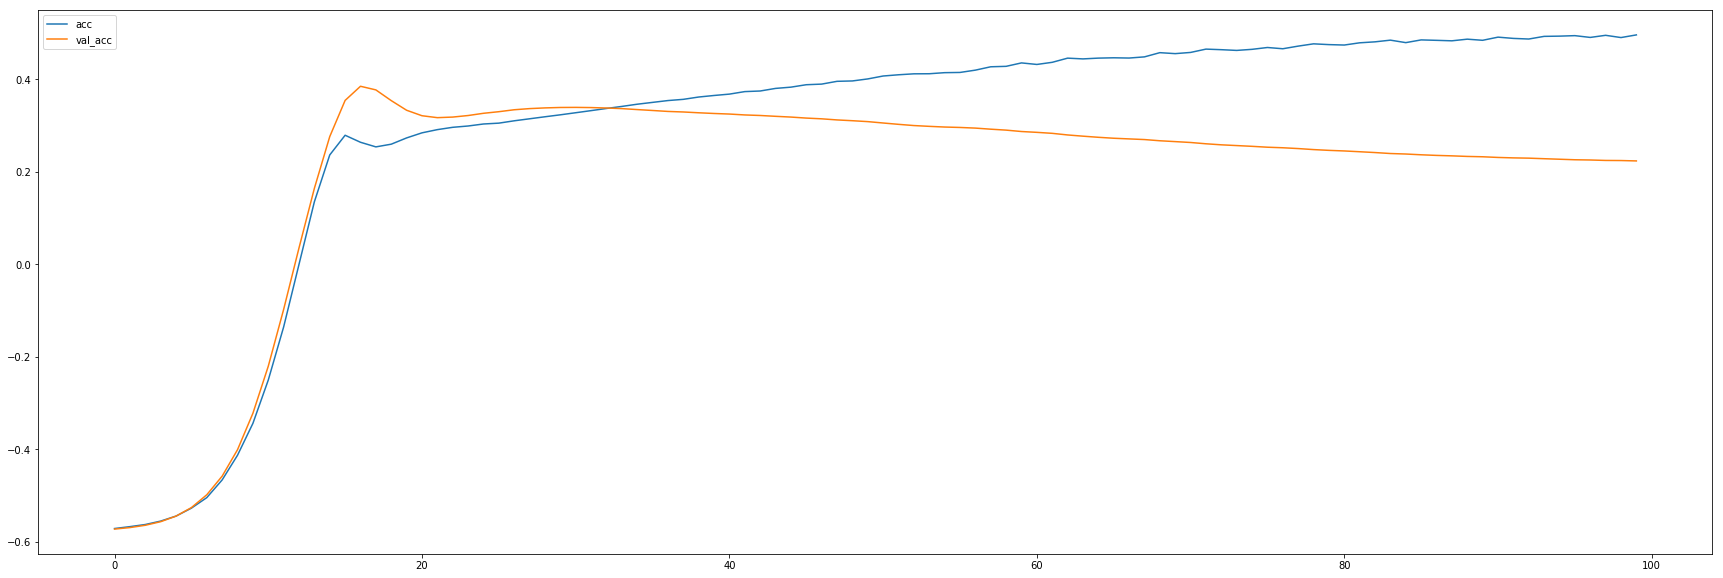

In [221]:
#sci-kit like training
model = keras_model(loss='mse', metrics=[gain_tf])
da = DACombine()
split = int(xTrain.shape[1] * 0.25)
xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
xTrain_a, yTrain_a = da.fit_predict(xTrain_a, yTrain_a, size=xTrain_a.shape[1]*16, distance=10, retarget=True, distribution=True, combine=True)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'), validation_data=(xVal, yVal), epochs=100, batch_size=64, verbose=0)
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot(figsize=(30,10))

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot(figsize=(30, 10))

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  58.712814


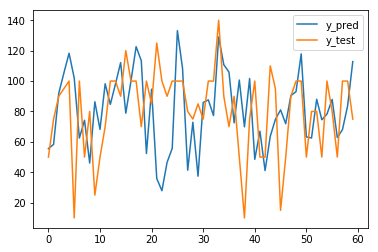

In [222]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean2(yTest.ravel(), yPred.ravel()))

In [211]:
# from sklearn.svm import SVC, LinearSVC, LinearSVR

# model = SVC(gamma='auto', kernel='rbf')
# model = LinearSVC()
# da = DACombine()
# split = int(xTrain.shape[0] * 0.25)
# #xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
# xTrain_a, yTrain_a = xTrain.copy(), yTrain.ravel().copy()
# #yTrain_a[yTrain_a < 75] = 50
# #yTrain_a[yTrain_a >= 75] = 100
# #xVal, yVal = xTrain[split:], yTrain[split:]
# xTrain_a, yTrain_a = da.fit_predict(xTrain_a, yTrain_a, size=xTrain_a.shape[1]*16, distance=5, retarget=True, distribution=True, combine=True)

# model.fit(xTrain_a, yTrain_a.ravel())

# yPred = model.predict(xTest)
# print(yPred - yTest.ravel())

# #model.classes_
# model.predict(xTrain_a)
# print("Gain mean:", gain_mean2(yTest.ravel(), yPred.ravel()))
# print("mse: ", mse(yTest.ravel(), yPred))

# print(yPred)

In [556]:
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression

def ultimatum_score(y_true, y_pred):
    res = MAX_GAIN - y_pred
    res[y_pred < y_true] = 0
    return res.mean()
    

class AcceptanceModel(object):
    def __init__(self, base_model=None, max_gain=MAX_GAIN, step=5, zero_one=True, metric=None):
        """
        :param base_model: a model with fit/predict functions (classification)
        :param max_gain: (int) the maximum possible offer/gain
        :param step: (int) band width for categorizing the possible values inteval
        :zero_one: (bool) if True use the classes 0/1 else -1/1
        :param metric: (function|callable) with two parameters (y_true, y_pred) returns the score of a prediction
        """
        self.base_model = base_model
        if base_model is None:
            self.base_model = LogisticRegression(penalty='l1', solver='liblinear')
        self.max_gain = max_gain
        self.zero_one = zero_one
        if self.zero_one:
            self.classes = [0, 1]
        else:
            self.classes = [-1, 1]
        self.offers = np.arange(0, max_gain, step)
        self.decision_line = 0
        if metric is None:
            metric = ultimatum_score
        self.metric = metric
        self._trained = False
    
    def _transform_train(self, x, y):
        xNew = []
        yNew = []
        for idx in np.arange(0, x.shape[0]):
            base = np.zeros((self.offers.shape[0], x.shape[1] + 1))
            base[:, :-1] = x[idx]
            base[:, -1] = self.offers / self.max_gain
            xNew.extend(base)
            base_y = (base[:, -1] >= (y[idx] / self.max_gain)).astype(int) #TODO #NOTE check
            if self.zero_one:
                base_y[base_y < 1] = -1
            yNew.extend(base_y)
        xNew = np.array(xNew)
        yNew = np.array(yNew)
        return xNew, yNew
    
    def _transform_predict(self, x):
        xNew = []
        for idx in np.arange(0, x.shape[0]):
            base = np.zeros((self.offers.shape[0], x.shape[1] + 1))
            base[:, :-1] = x[idx]
            base[:, -1] = self.offers / self.max_gain
            xNew.extend(base)
        xNew = np.array(xNew)
        return xNew        
    
    def fit(self, xTrain, yTrain, **kwargs):
        xTrain_, yTrain_ = xTrain, yTrain
        split = int(xTrain.shape[0] * 0.75)
        xTrain_only, yTrain_only = xTrain[:split], yTrain[:split]
        xVal_only, yVal_only = xTrain[split:], yTrain[split:].ravel()
        
        xTrain_only, yTrain_only = self._transform_train(xTrain_only, yTrain_only)
        self.base_model.fit(xTrain_only, yTrain_only)
        top_decision_line = None
        top_score = float('-inf')
        xVal_only_ext = self._transform_predict(xVal_only)
        for decision_line in np.linspace(self.classes[0], self.classes[1]):
            yPred = self._predict(self.base_model, xVal_only, decision_line)
            score = self.metric(yVal_only, yPred)
            if score > top_score:
                top_score = score
                top_decision_line = decision_line
        self.decision_line = top_decision_line
            
        self._trained = True
    
    def _predict(self, model, xTest, decision_line):
        xShape = xTest.shape
        xTest = self._transform_predict(xTest)
        
        y_pred = model.predict(xTest)
        res = []
        for idx in np.arange(0, xShape[0]):
            mask = np.arange(idx*self.offers.shape[0], (idx+1)*self.offers.shape[0])
            group_y = y_pred[mask]
            group_x = xTest[mask]
            target = group_x[(group_y > decision_line).argmax()][-1]
            res.append(target * self.max_gain)
        return np.array(res)
        
    def predict(self, xTest, **kwargs):
        return self._predict(self.base_model, xTest, self.decision_line)
#         xTest_ = xTest
#         xShape = xTest.shape
#         xTest = self._transform_predict(xTest)
        
#         y_pred = self.base_model.predict(xTest)
#         res = []
#         decision_line = 1/3.0
#         if not self.zero_one:
#             decision_line = -3/3.0
#         for idx in np.arange(0, xShape[0]):
#             mask = np.arange(idx*self.offers.shape[0], (idx+1)*self.offers.shape[0])
#             group_y = y_pred[mask]
#             group_x = xTest[mask]
#             target = group_x[(group_y > decision_line).argmax()][-1]
#             res.append(target * self.max_gain)
#         return np.array(res)
        
        
        

# xTrain_s, yTrain_s = xTrain.copy(), yTrain.ravel().copy()
# xTrain_new = []
# yTrain_new = []
# nb_offers = int(MAX_GAIN)
# offers = np.arange(0, MAX_GAIN, 1)
# offset = 0
# for idx in np.arange(0, xTrain_s.shape[0]):
#     base = np.zeros((offers.shape[0], xTrain_s.shape[1] + 1))
#     base[:, :-1] = xTrain_s[idx]
#     base[:, -1] = offers/MAX_GAIN
#     xTrain_new.extend(base)
#     yTrain_new.extend((base[:, -1] >= (yTrain_s[idx] + offset)/MAX_GAIN).astype(int))

# xTrain_new = np.array(xTrain_new)
# yTrain_new = np.array(yTrain_new)
# split = int(xTrain_new.shape[0] * 0.25)
# xTrain_l, yTrain_l = xTrain_new[:split], yTrain_new[:split]
# xVal_l, yVal_l = xTrain_new[split:], yTrain_new[split:]
# model = SVC(gamma='auto')
# #model = LogisticRegression(penalty='l1', solver='liblinear')
# #model = LinearRegression()
# model.fit(xTrain_new, yTrain_new)

# def predict(arg):
#     arg_s = []
#     for idx in np.arange(0, arg.shape[0]):
#         base = np.zeros((offers.shape[0], arg.shape[1]+1))
#         base[:, :-1] = arg[idx]
#         base[:, -1] = offers/MAX_GAIN
#         arg_s.extend(base)
#     arg_s = np.array(arg_s)
#     print(arg_s.shape)
#     y_pred = model.predict(arg_s)
#     res = []
#     for idx in np.arange(0, arg.shape[0]):
#         mask = np.arange(idx*offers.shape[0], (idx+1)*offers.shape[0])
#         group_y = y_pred[mask]
#         group_x = arg_s[mask]
#         target = group_x[group_y.argmax()][-1]
#         res.append(target*MAX_GAIN)
#     return np.array(res)
#     #return arg_s, y_pred
    

In [2]:
from sklearn.ensemble.bagging import BaggingRegressor, BaggingClassifier, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.svm import NuSVC, LinearSVC, LinearSVR, SVR, NuSVR

#LinearSVR, zero_one=True: 87
#SVR, zero_one=True: 70

svc = SVC(gamma='scale', class_weight='balanced')
model = AcceptanceModel(LinearRegression(), step=1, zero_one=False)
xTrain_, yTrain_ = xTrain, yTrain
#xTrain_, yTrain_ = da.fit_predict(xTrain, yTrain, distribution=False, retarget=True, combine=False)
model.fit(xTrain_, yTrain_)
res = model.predict(xTest)
gain_mean2(yTest.ravel(), res.ravel())

NameError: name 'SVC' is not defined

In [ ]:
res

In [574]:
m = LogisticRegression(penalty='l1', solver='saga', multi_class='ovr')
m.fit(xTrain_, yTrain_.ravel())
pr = m.predict(xTest)
gain_mean2(yTest.ravel(), pr)

90.83333333333333

In [401]:
print(pr)
print(yTest.ravel())

[ 70. 100.  50. 120. 110. 110.  20.  90.   0.  90. 100. 110. 110.  30.
 130.  90. 130. 110. 130.  50.  20.  40.  40.  40.  20. 110. 110. 100.
  20.  70.  90.  70.  30. 120. 110.  90. 100.  20.  30. 110.  40.  20.
  50.  50.  70.  20. 100.  70.  20.  30.  20.  70. 100.  60.  50.   0.
  70.  50.  50.  30.]
[ 50.  75.  90.  95. 100.  10. 100.  50.  80.  25.  50.  70. 100. 100.
  90. 120. 100. 100.  70. 100.  85. 125. 100.  90. 100. 100. 100.  80.
  75.  85.  75. 100. 100. 140.  90.  70.  90.  50.  10.  75. 100.  50.
  50. 110.  95.  15.  50.  90. 100. 100.  50.  80.  80.  50. 100.  80.
  50. 100. 100.  75.]
